# Notebook 04: Wealth vs. Income Inequality

## Why do the Nordics have low income inequality but high wealth inequality?

Income and wealth inequality are related but distinct phenomena. The Nordic
countries present a striking paradox: they have among the lowest income Gini
coefficients in the developed world, but among the **highest** wealth
concentration.

### The Nordic wealth paradox

Several mechanisms explain this:

1. **Funded pensions**: Countries with large public pension systems (like Sweden's
   AP funds) accumulate wealth collectively rather than individually. Private
   pension wealth is concentrated among higher earners.

2. **Universal services**: When healthcare, education, and childcare are publicly
   provided, lower-income households have less need for precautionary savings.
   This paradoxically increases *measured* wealth inequality.

3. **Leveraged homeownership**: High homeownership rates combined with mortgage
   debt mean many households have low net wealth despite owning property.

4. **Tax treatment**: Historically favorable tax treatment of capital income and
   wealth in some Nordic countries (Sweden abolished its wealth tax in 2007).

### Key references
- Pfeffer & Waitkus (2021): wealth inequality in cross-national perspective
- Berman, Milanovic & Erixon (2023): the Nordic wealth paradox

In [1]:
import sys
sys.path.insert(0, '..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

from data.config import FOCUS_COUNTRIES, EXTENDED_COUNTRIES, COUNTRY_NAMES
from data.plotting import (set_style, country_color, country_name,
                           save_figure, annotate_countries)
from data import wid, swiid

set_style()

***
## 1. Income Gini vs. Wealth Gini: The Paradox Scatter

This scatter plot places income inequality on the x-axis and wealth inequality
on the y-axis. If income and wealth inequality were perfectly correlated, all
countries would lie on the diagonal. Instead, the Nordics cluster in the
**lower-left to upper-left** area: low income Gini, high wealth concentration.

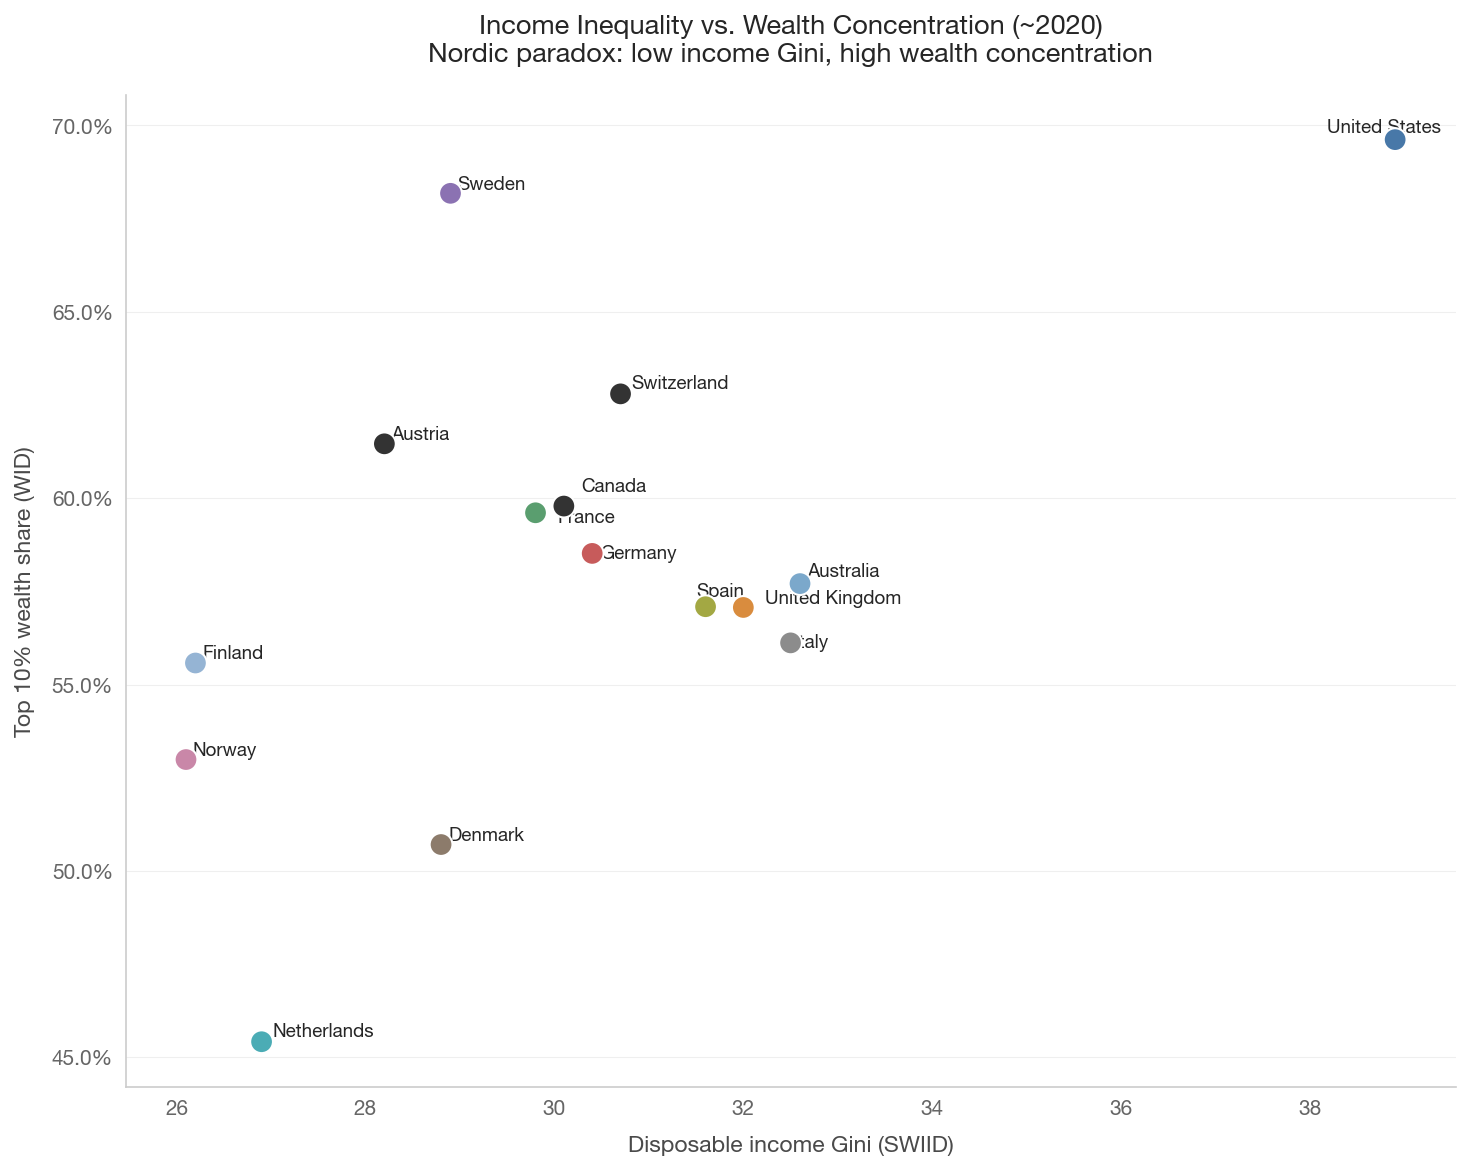

In [2]:
scatter_countries = ['US', 'GB', 'FR', 'DE', 'SE', 'DK', 'NO', 'FI',
                     'NL', 'IT', 'ES', 'CA', 'AU', 'AT', 'CH']

# Income Gini from SWIID
income_gini = swiid.get_gini(scatter_countries, gini_type='disp',
                              start_year=2017, end_year=2022)

# Wealth: top 10% share from WID as a proxy for wealth concentration
wealth_top10 = wid.get_wealth_shares(
    scatter_countries,
    percentiles=['p90p100'],
    start_year=2017, end_year=2022,
)

if not income_gini.empty and not wealth_top10.empty:
    # Take most recent per country
    ig = (income_gini.sort_values('year', ascending=False)
          .groupby('country_code').first().reset_index())
    wt = (wealth_top10.sort_values('year', ascending=False)
          .groupby('country').first().reset_index())
    wt = wt.rename(columns={'country': 'country_code', 'value': 'wealth_top10'})

    merged = ig.merge(wt[['country_code', 'wealth_top10']], on='country_code')

    if not merged.empty:
        fig, ax = plt.subplots(figsize=(10, 8))
        colors = [country_color(c) for c in merged['country_code']]
        ax.scatter(merged['gini'], merged['wealth_top10'],
                   c=colors, s=120, zorder=5, edgecolors='white', linewidth=1)

        annotate_countries(ax, merged['gini'].values,
                           merged['wealth_top10'].values,
                           merged['country_code'].values)

        ax.set_xlabel('Disposable income Gini (SWIID)')
        ax.set_ylabel('Top 10% wealth share (WID)')
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
        ax.set_title('Income Inequality vs. Wealth Concentration (~2020)\n'
                     'Nordic paradox: low income Gini, high wealth concentration',
                     fontsize=13)
        plt.tight_layout()
        save_figure(fig, '04_income_vs_wealth_gini')
        plt.show()
    else:
        print('Could not merge income and wealth data.')
else:
    print('Income Gini or wealth share data not available.')

***
## 2. Top 1% and Top 10% Wealth Shares Over Time

Wealth concentration has its own dynamics. In some countries, the top wealth
shares declined during the 20th century (war, taxation, inflation eroding
capital) and have been rising since the 1980s. In others, the pattern differs.

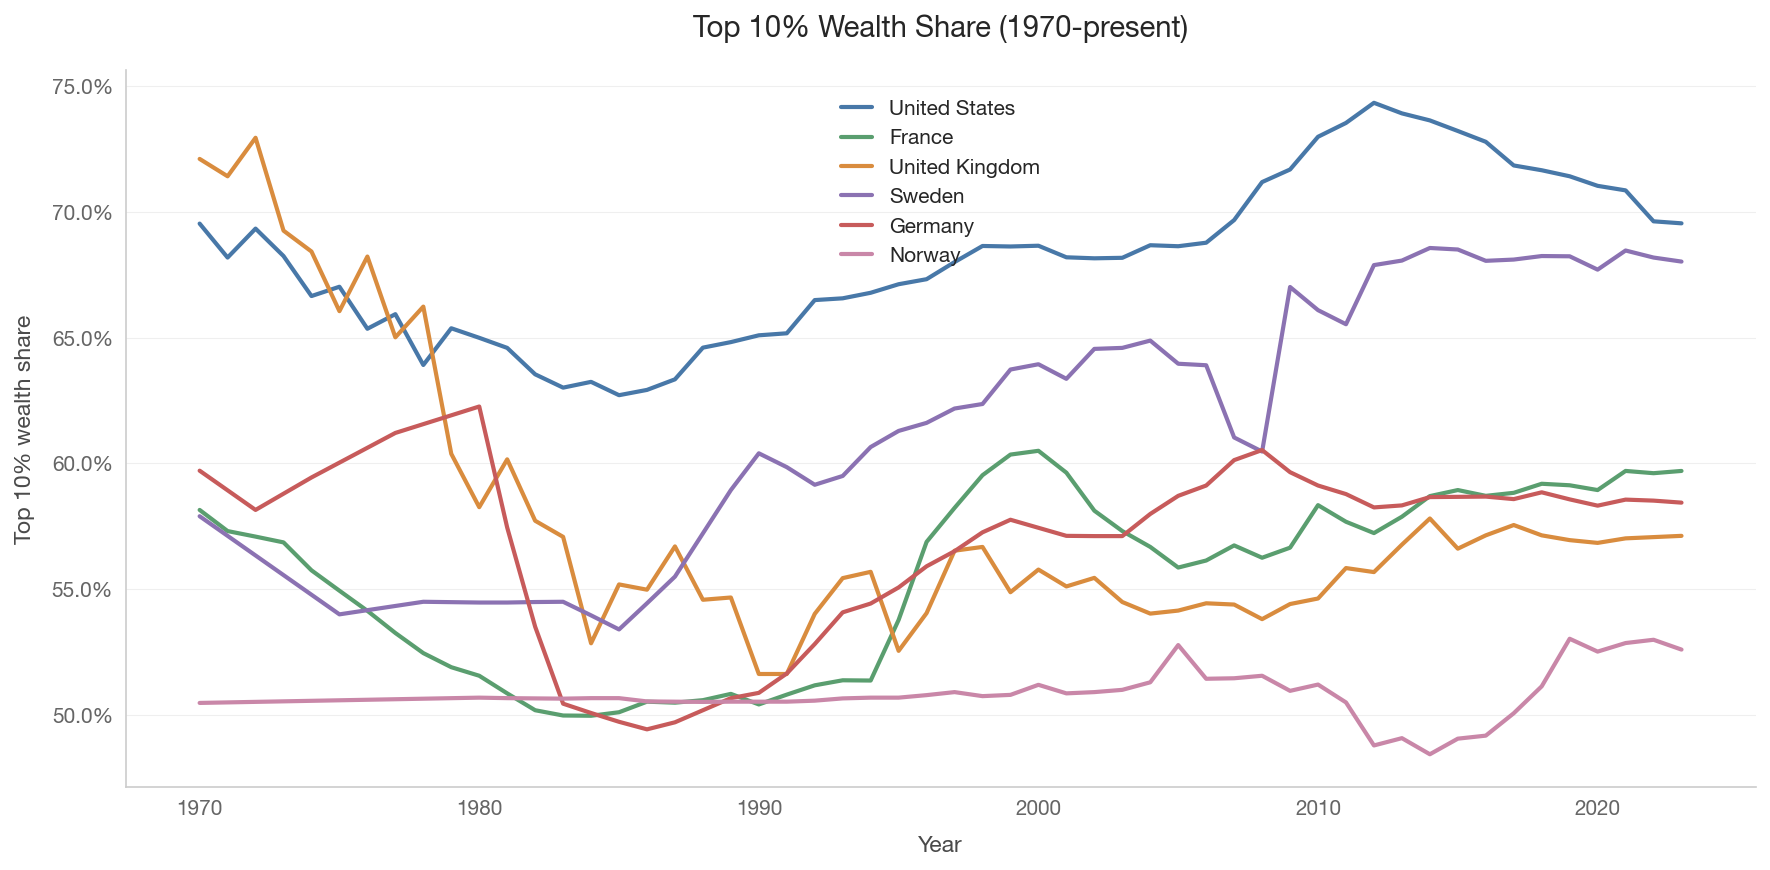

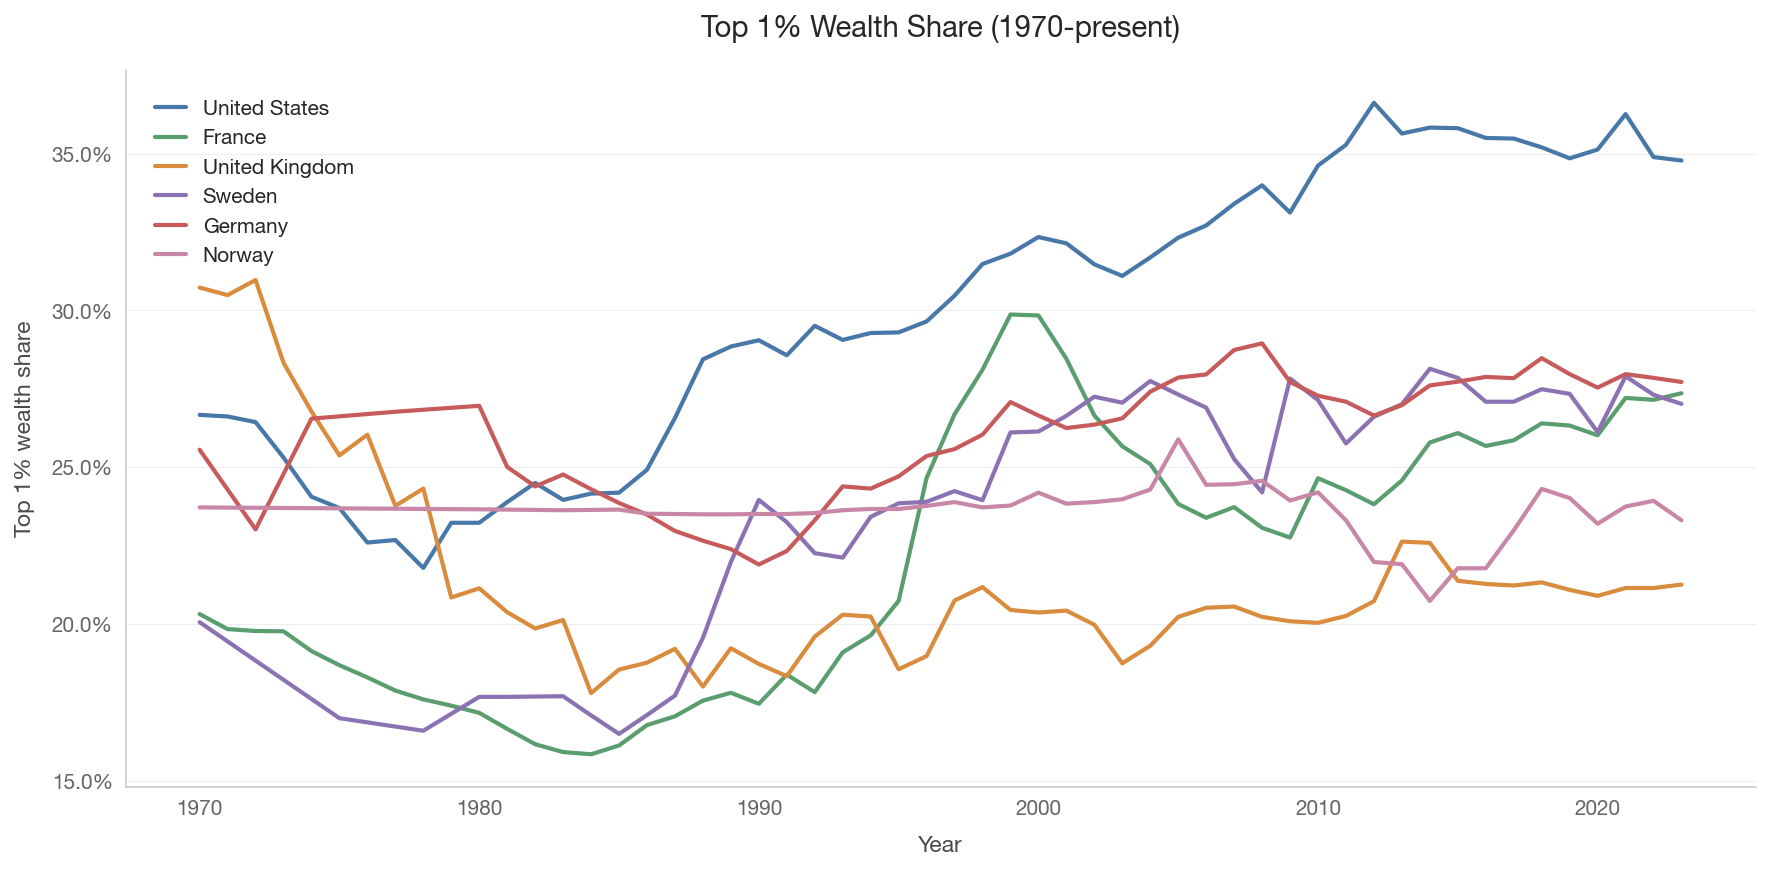

In [3]:
ts_countries = ['US', 'FR', 'GB', 'SE', 'DE', 'NO']

for pct, pct_label in [('p90p100', 'Top 10%'), ('p99p100', 'Top 1%')]:
    wealth_ts = wid.get_wealth_shares(
        ts_countries, percentiles=[pct], start_year=1970, end_year=2023
    )

    if not wealth_ts.empty:
        fig, ax = plt.subplots(figsize=(12, 6))

        for cc in ts_countries:
            data = wealth_ts[wealth_ts['country'] == cc].sort_values('year')
            if not data.empty:
                ax.plot(data['year'], data['value'],
                        color=country_color(cc), linewidth=2,
                        label=country_name(cc))

        ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
        ax.set_xlabel('Year')
        ax.set_ylabel(f'{pct_label} wealth share')
        ax.set_title(f'{pct_label} Wealth Share (1970-present)', fontsize=14)
        ax.legend()
        plt.tight_layout()
        save_figure(fig, f'04_wealth_{pct}_timeseries')
        plt.show()
    else:
        print(f'Wealth share data not available for {pct_label}.')

***
## 3. Top Income Shares vs. Top Wealth Shares

Are income and wealth concentration moving together? In some countries,
rising top income shares have translated into rising wealth concentration.
In others, the relationship is weaker.

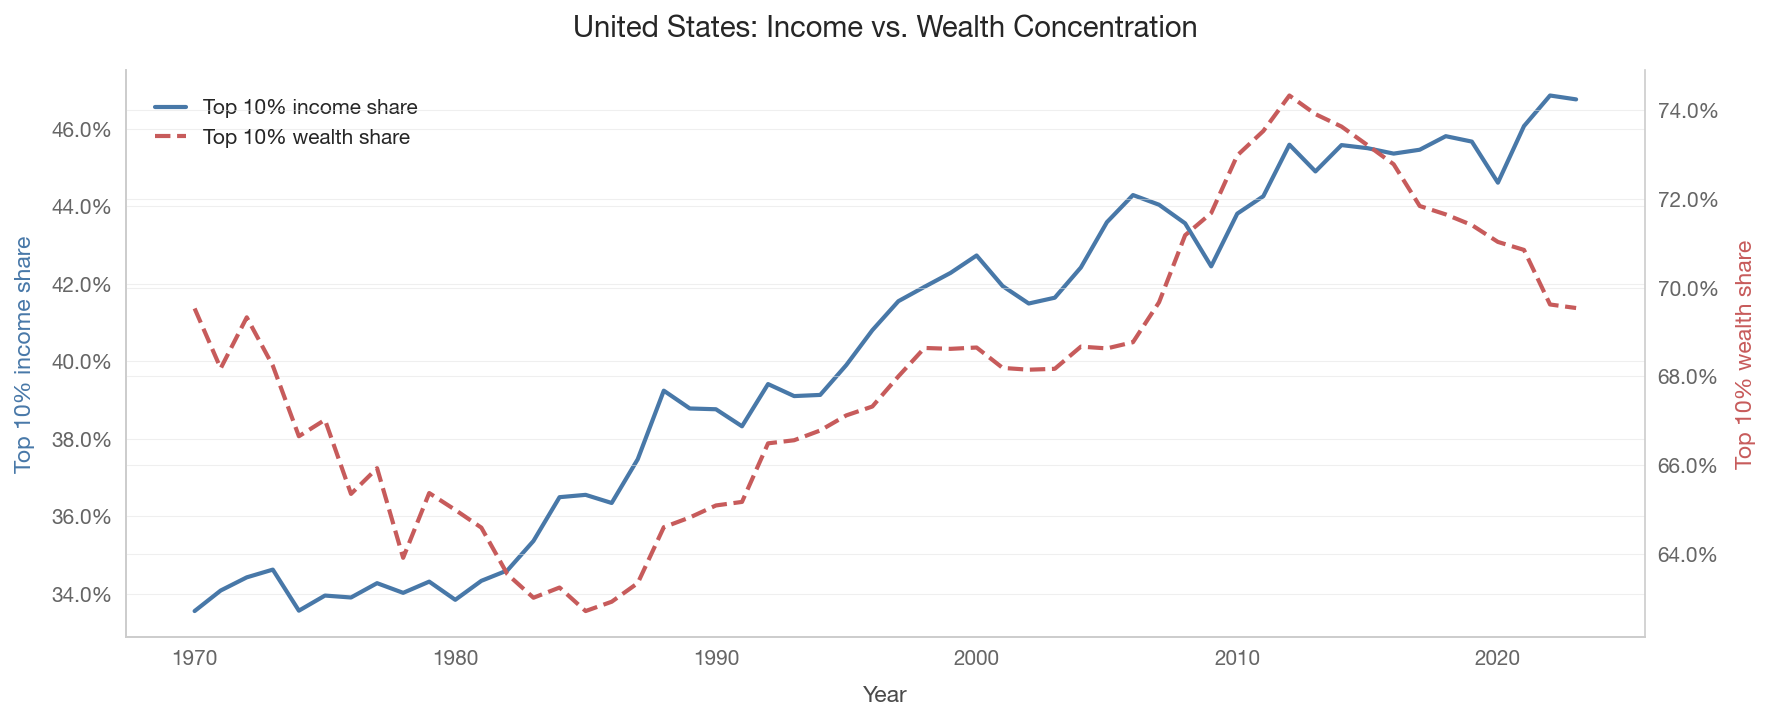

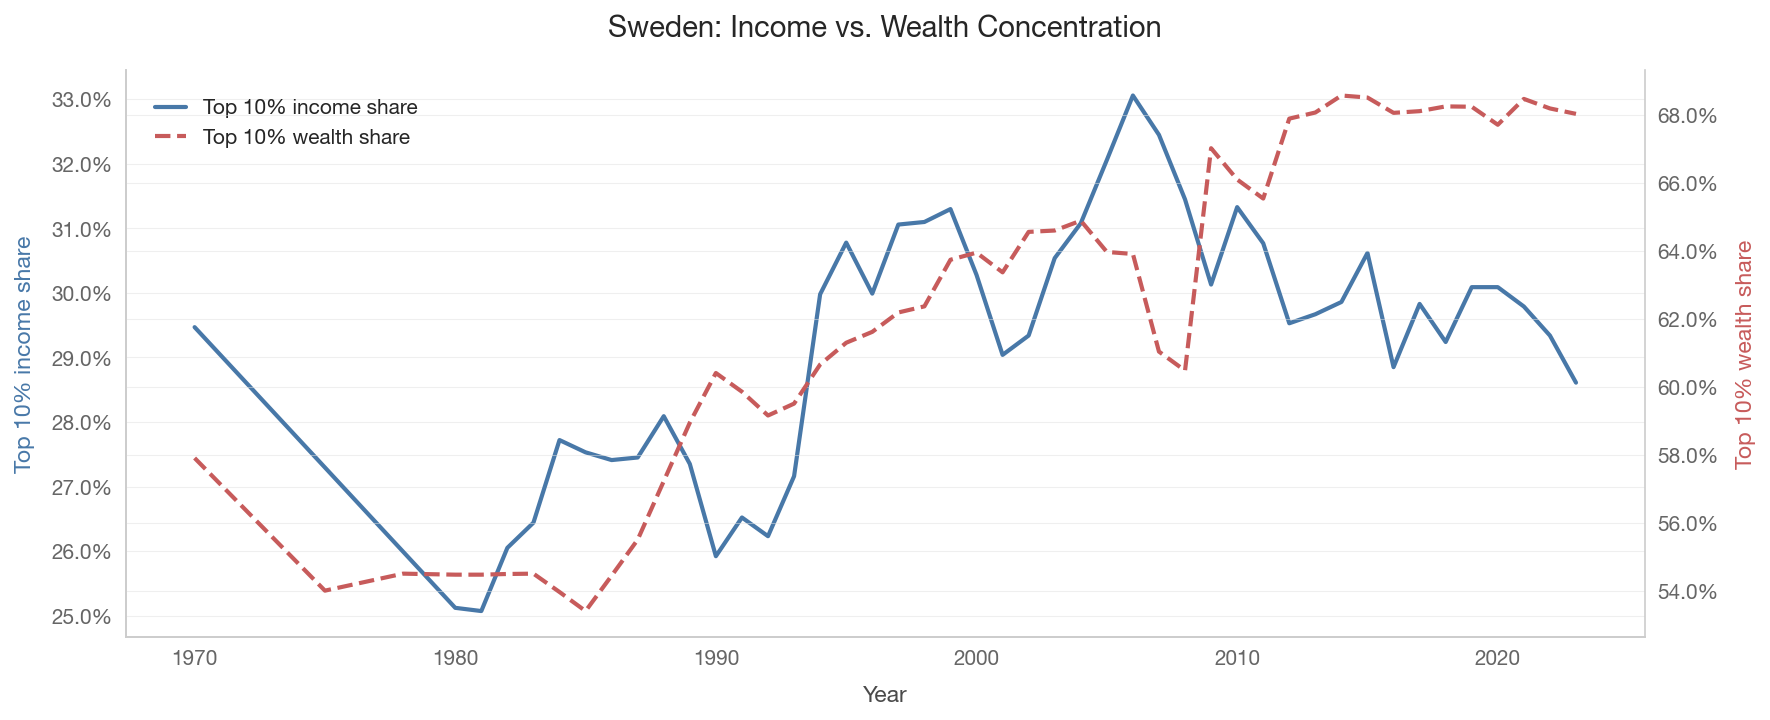

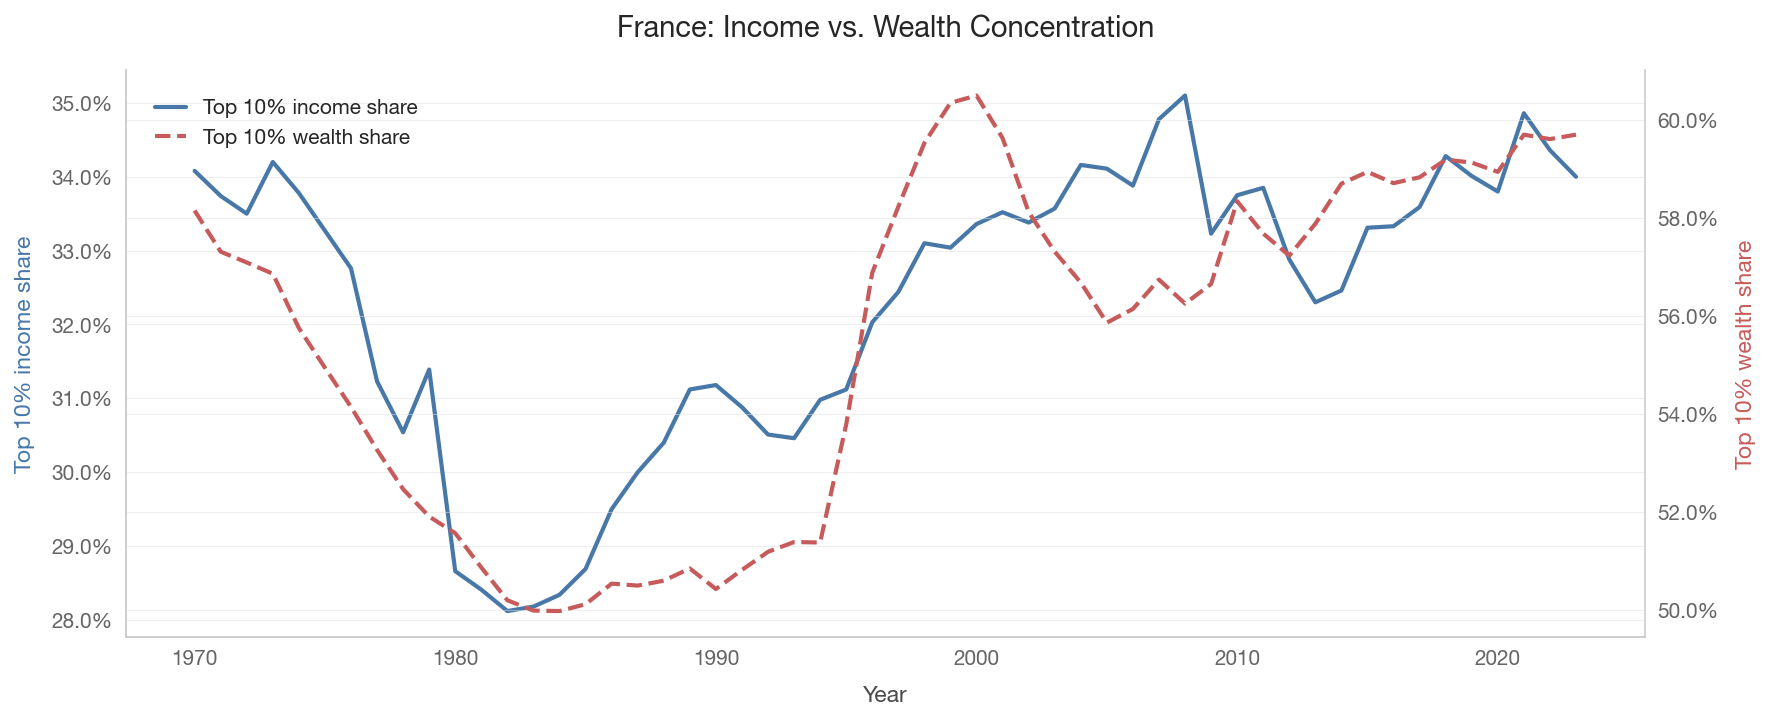

In [4]:
for cc in ['US', 'SE', 'FR']:
    income_ts = wid.get_top_shares_timeseries(
        [cc], percentile='p90p100', concept='pretax', start_year=1970
    )
    wealth_ts = wid.get_wealth_shares(
        [cc], percentiles=['p90p100'], start_year=1970, end_year=2023
    )

    if not income_ts.empty and not wealth_ts.empty:
        fig, ax1 = plt.subplots(figsize=(12, 5))
        ax2 = ax1.twinx()
        ax2.spines['right'].set_visible(True)
        ax2.spines['right'].set_color('#cccccc')

        inc = income_ts[income_ts['country'] == cc].sort_values('year')
        wth = wealth_ts[wealth_ts['country'] == cc].sort_values('year')

        ax1.plot(inc['year'], inc['value'], color='#4878a8', linewidth=2,
                 label='Top 10% income share')
        ax2.plot(wth['year'], wth['value'], color='#c75b5b', linewidth=2,
                 linestyle='--', label='Top 10% wealth share')

        ax1.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
        ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
        ax1.set_xlabel('Year')
        ax1.set_ylabel('Top 10% income share', color='#4878a8')
        ax2.set_ylabel('Top 10% wealth share', color='#c75b5b')
        ax1.set_title(f'{country_name(cc)}: Income vs. Wealth Concentration',
                      fontsize=14)

        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

        plt.tight_layout()
        save_figure(fig, f'04_income_vs_wealth_ts_{cc}')
        plt.show()
    else:
        print(f'Data not available for {country_name(cc)}.')


***
## 4. Bottom 50% Wealth Share

The bottom 50% typically owns very little wealth — often close to zero
or even negative (when debts exceed assets). This is true even in
relatively egalitarian countries.

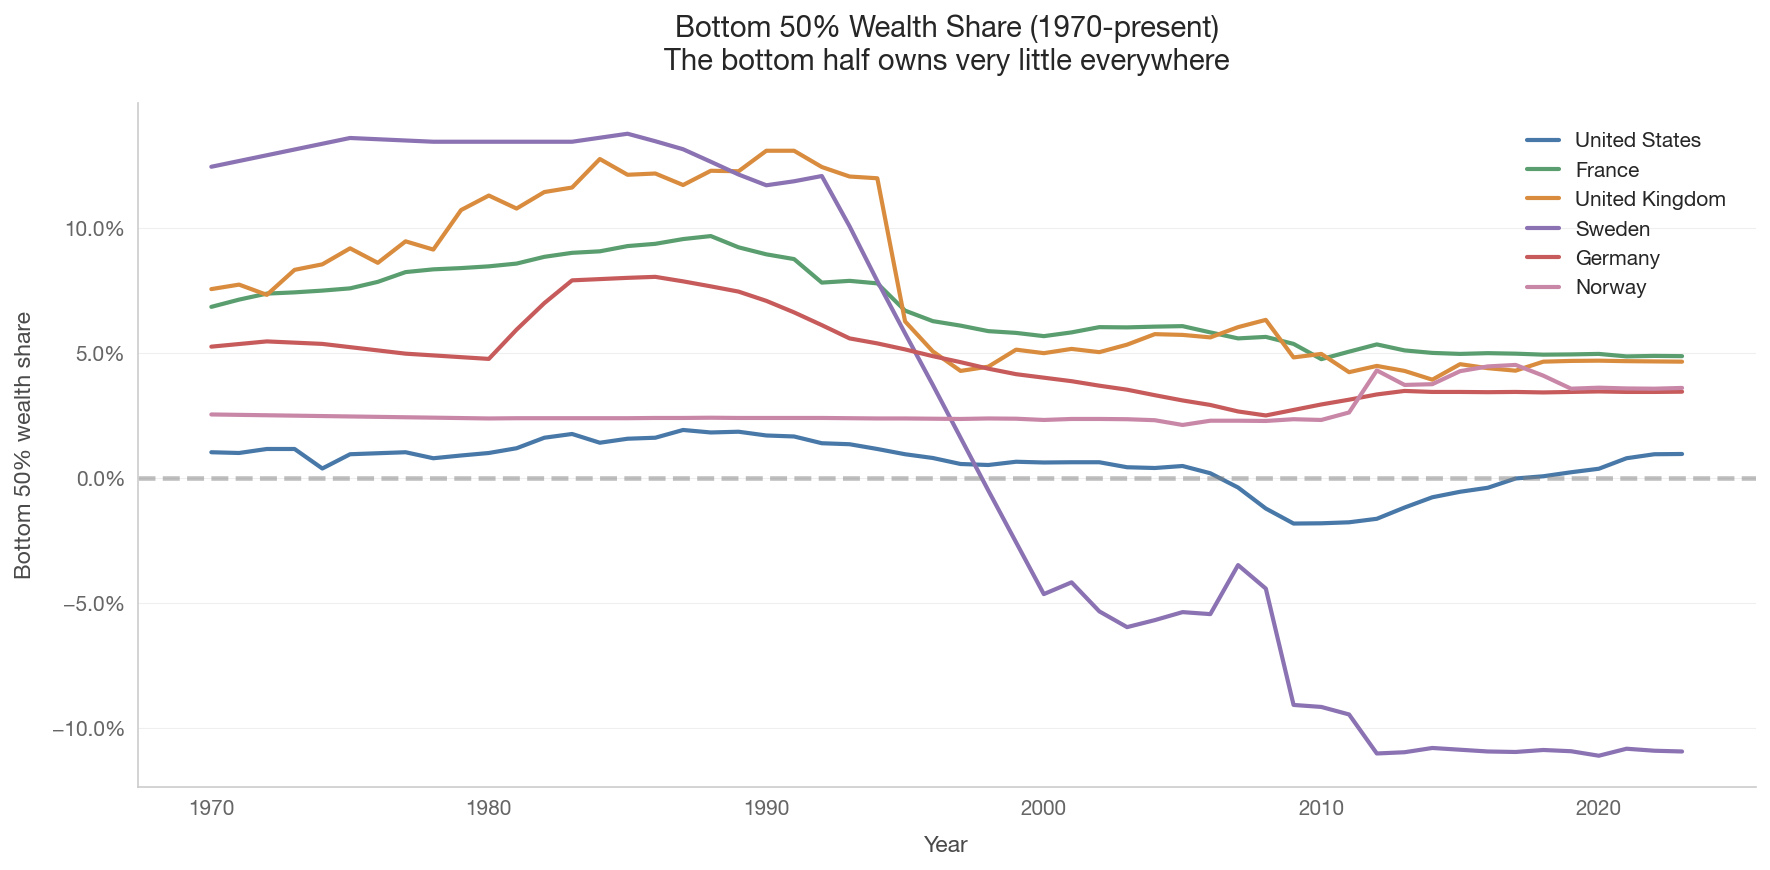

In [5]:
bottom50_wealth = wid.get_wealth_shares(
    ts_countries, percentiles=['p0p50'], start_year=1970, end_year=2023
)

if not bottom50_wealth.empty:
    fig, ax = plt.subplots(figsize=(12, 6))

    for cc in ts_countries:
        data = bottom50_wealth[bottom50_wealth['country'] == cc].sort_values('year')
        if not data.empty:
            ax.plot(data['year'], data['value'],
                    color=country_color(cc), linewidth=2,
                    label=country_name(cc))

    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.set_xlabel('Year')
    ax.set_ylabel('Bottom 50% wealth share')
    ax.set_title('Bottom 50% Wealth Share (1970-present)\n'
                 'The bottom half owns very little everywhere', fontsize=14)
    ax.legend()
    plt.tight_layout()
    save_figure(fig, '04_wealth_bottom50_timeseries')
    plt.show()
else:
    print('Bottom 50% wealth share data not available.')

***
## 5. Explaining the Nordic Paradox

A visual decomposition of why wealth inequality can be high even when
income inequality is low.

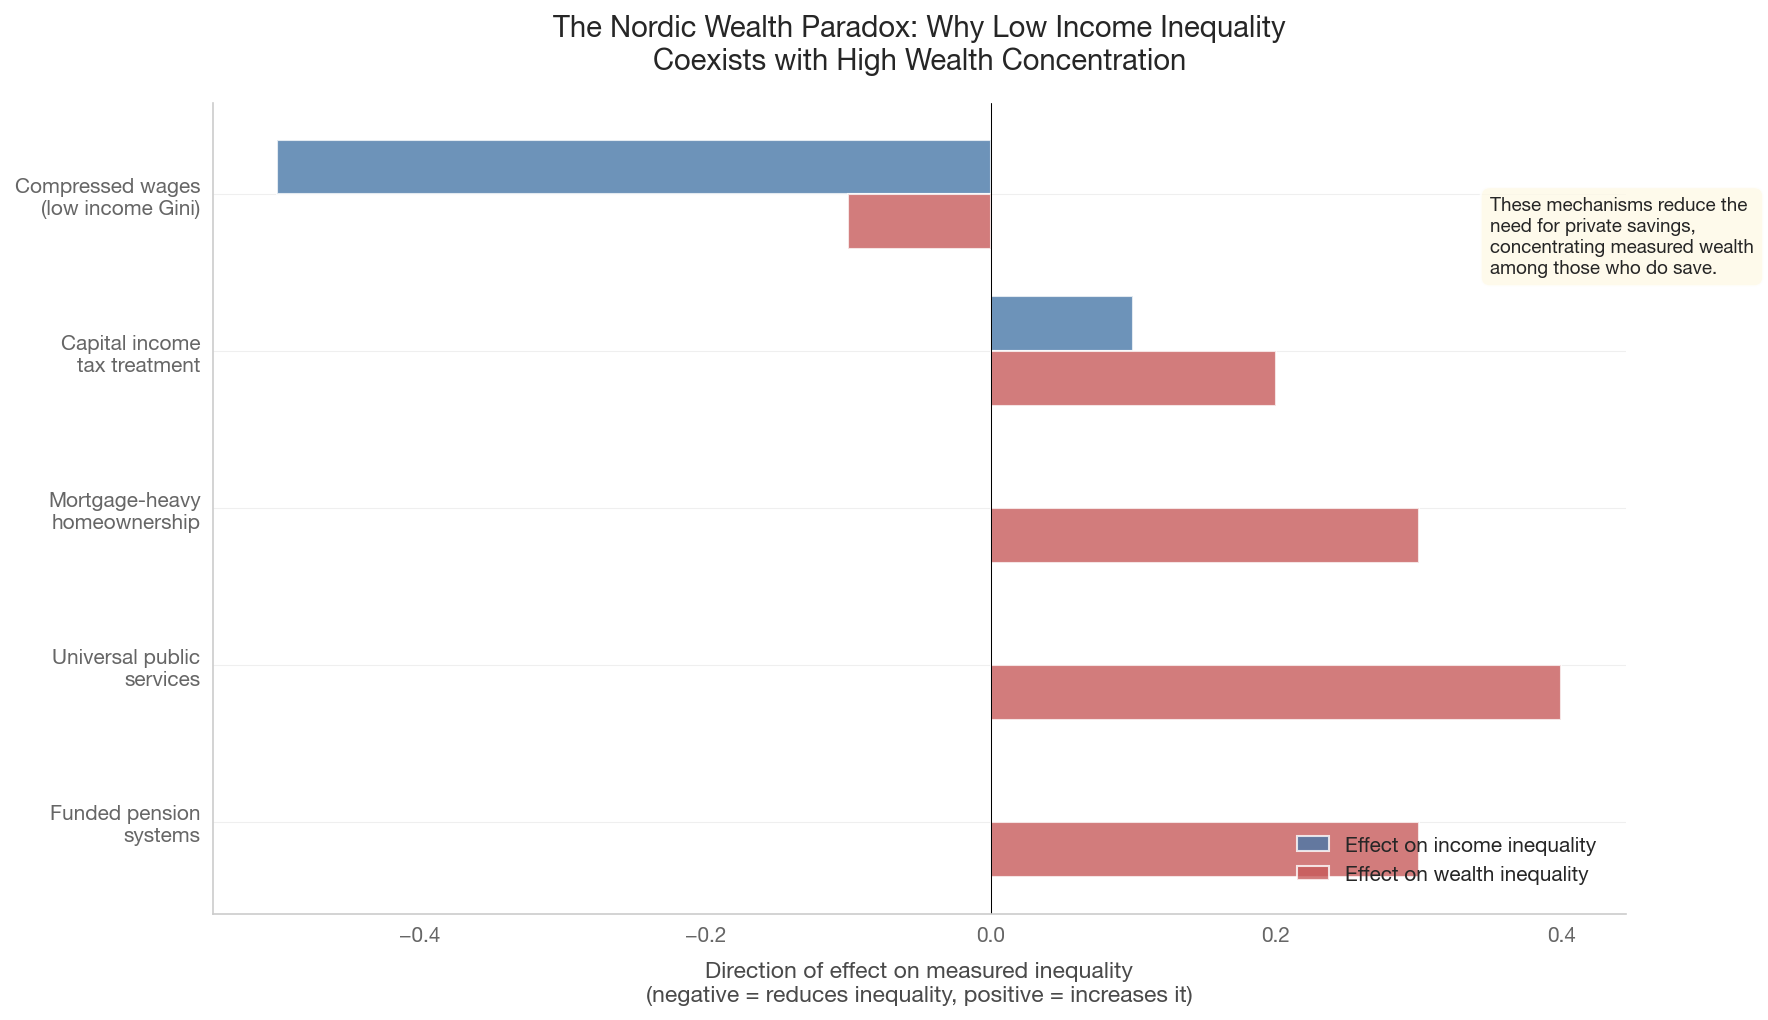

In [6]:
fig, ax = plt.subplots(figsize=(12, 7))

mechanisms = [
    'Funded pension\nsystems',
    'Universal public\nservices',
    'Mortgage-heavy\nhomeownership',
    'Capital income\ntax treatment',
    'Compressed wages\n(low income Gini)',
]

effects_on_income = [0, 0, 0, 0.1, -0.5]
effects_on_wealth = [0.3, 0.4, 0.3, 0.2, -0.1]

x = np.arange(len(mechanisms))
width = 0.35

bars1 = ax.barh(x + width/2, effects_on_income, width,
                label='Effect on income inequality',
                color='#4878a8', alpha=0.8)
bars2 = ax.barh(x - width/2, effects_on_wealth, width,
                label='Effect on wealth inequality',
                color='#c75b5b', alpha=0.8)

ax.set_yticks(x)
ax.set_yticklabels(mechanisms)
ax.axvline(x=0, color='black', linewidth=0.5)
ax.set_xlabel('Direction of effect on measured inequality\n'
              '(negative = reduces inequality, positive = increases it)')
ax.set_title('The Nordic Wealth Paradox: Why Low Income Inequality\n'
             'Coexists with High Wealth Concentration', fontsize=14)
ax.legend(loc='lower right')

ax.annotate('These mechanisms reduce the\nneed for private savings,\n'
            'concentrating measured wealth\namong those who do save.',
            xy=(0.35, 3.5), fontsize=9, fontstyle='italic',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='#fef9e7', alpha=0.8))

plt.tight_layout()
save_figure(fig, '04_nordic_paradox_mechanisms')
plt.show()


***
## Key Takeaways

1. **Income and wealth inequality are distinct.** Countries with low income
   inequality can have high wealth concentration, and vice versa.

2. **The Nordic paradox is real.** Sweden, Denmark, and Norway have among the
   highest wealth concentration in the OECD despite low income inequality.

3. **Public provision reduces private accumulation.** Universal services and
   public pensions reduce the need for precautionary savings, paradoxically
   increasing measured wealth inequality.

4. **Wealth concentration has been rising.** In most countries, top wealth
   shares have increased since the 1980s, though patterns vary by country.

5. **The bottom 50% owns very little everywhere.** This is a near-universal
   feature of wealth distributions, even in egalitarian societies.